# Базовая подгрузка

In [1]:
%pylab inline
import pandas as pd
pd.set_option('display.max_rows', 500)

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [3]:
tr_types = pd.read_csv('tr_types.csv', sep = ';')
print(tr_types.shape)
tr_types.head()

(155, 2)


,tr_type,tr_description
0,3200,Плата за предоставление услуг посредством моби...
1,3210,Плата за предоставление отчета по счету карты ...
2,3800,Плата за обслуживание банковской карты (за пер...
3,4000,Плата за получение наличных в Сбербанке
4,4001,Плата за получение наличных в Сбербанке (в дру...


In [4]:
tr_mcc_codes = pd.read_csv('tr_mcc_codes.csv', sep = ';')
print(tr_mcc_codes.shape)
tr_mcc_codes.head()

(184, 2)


,mcc_code,mcc_description
0,742,Ветеринарные услуги
1,1711,"Генеральные подрядчики по вентиляции, теплосна..."
2,1731,Подрядчики по электричеству
3,1799,"Подрядчики, специализированная торговля — нигд..."
4,2741,Разнообразные издательства/печатное дело


In [5]:
transactions = pd.read_csv('transactions.csv', sep = ',')
print(transactions.shape)
transactions.head()

(6849346, 6)


,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN
1,39026145,1 10:19:29,6011,7010,56147.89,NaN
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN
4,39026145,2 15:33:42,5499,1010,-920.83,NaN


In [6]:
customers_gender_train = pd.read_csv('customers_gender_train.csv', sep = ',')
print(customers_gender_train.shape)
customers_gender_train.head()

(12000, 2)


,customer_id,gender
0,75562265,0
1,10928546,1
2,69348468,1
3,84816985,1
4,61009479,0


In [7]:
customers_gender = customers_gender_train.set_index('customer_id')

# Готовлю данные

In [10]:
train_transactions = transactions[transactions.amount < 0].copy()
train_transactions['day'] = train_transactions.tr_datetime.apply(lambda dt: dt.split()[0]).astype(int)
train_grid = pd.DataFrame(columns=train_transactions.mcc_code.unique(), 
                          index=train_transactions.day.unique()).unstack().reset_index()
train_grid.shape

(84088, 3)

In [11]:
train_grid.columns = ['mcc_code', 'day', 'amount']
train_grid.drop('amount', axis = 1, inplace = True)
train_grid.head()

,mcc_code,day
0,4814,0
1,4814,1
2,4814,2
3,4814,3
4,4814,4


In [12]:
sumg0 = train_transactions.groupby(['day', 'mcc_code'])[['amount']].sum().reset_index()
sumg0.head()

,day,mcc_code,amount
0,0,742,-12352.54
1,0,1799,-1456027.19
2,0,3000,-2352125.13
3,0,3501,-33577.34
4,0,4111,-27400.17


In [13]:
train_long = train_grid.merge(sumg0, on = ['day', 'mcc_code'], how = 'left').fillna(0)

In [15]:
shift = 500
train_long['lamount'] = np.log(-train_long['amount']+shift)

In [16]:
train_long.head()

,mcc_code,day,amount,lamount
0,4814,0,-11098744.26,16.222388
1,4814,1,-7881825.53,15.880134
2,4814,2,-6777480.45,15.729190
3,4814,3,-9277943.73,16.043204
4,4814,4,-9999757.21,16.118121


In [22]:
train_wide = train_long.pivot(index = 'day', columns = 'mcc_code', values = 'lamount')
train_wide.shape, len(unique(train_transactions['day'])), len(unique(train_transactions['mcc_code']))

((457, 184), 457, 184)

In [45]:
train_wide.head()

mcc_code,742,1711,1731,1799,2741,3000,3351,3501,4111,4112,...,8299,8398,8641,8699,8999,9211,9222,9311,9399,9402
day,,,,,,,,,,,,,,,,,,,,,
0,9.461297,6.214608,6.214608,14.191566,6.214608,14.671042,6.214608,10.436388,10.236388,14.680378,...,6.214608,6.214608,6.214608,6.214608,13.597727,6.214608,6.214608,6.214608,10.439652,6.214608
1,6.214608,6.214608,6.214608,6.214608,6.214608,14.849240,6.214608,9.545060,10.563092,14.299924,...,6.214608,13.016337,6.214608,6.214608,13.779338,6.214608,6.214608,6.214608,9.388835,6.214608
2,6.214608,6.214608,6.214608,6.214608,6.214608,14.002089,6.214608,11.559115,7.956302,13.975219,...,6.214608,6.214608,8.033594,6.214608,12.589548,6.214608,6.214608,10.439652,11.572241,6.214608
3,6.214608,6.214608,6.214608,6.214608,6.214608,15.630975,11.527183,10.619533,10.423486,14.419914,...,6.214608,6.610710,6.214608,6.214608,13.234481,6.214608,8.515558,6.214608,9.608914,6.214608
4,10.268080,8.370562,6.214608,6.214608,6.214608,15.641376,6.214608,12.655812,10.643692,14.453210,...,6.214608,6.214608,6.214608,6.214608,13.370887,6.214608,6.214608,6.214608,10.796093,6.214608


# Готовлю общие функции

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [24]:
def s2df(the_series):
    df = the_series.reset_index()
    df.columns = ['day', 'lamount']
    return df
def add_30_days(df):
    maxday = max(df['day'])
    df = pd.concat([df, pd.DataFrame({'day':arange(maxday+1, maxday+31), 'lamount':999})])
    df.index = df.day
    return df
def add_time_features_01(df):
    '''
    Adds weekday, monthday as numbers
    '''
    df['week_day'] = df['day'] % 7
    df['dt']= np.datetime64('2014-08-01')+df.day
    df['month_day'] = df['dt'].apply(lambda dt:dt.day)
    # убираю эту фичу, ибо она не число
    df.drop('dt', axis = 1, inplace = True)
    return df
def split1m(df):
    tr_index = df['day']<=(max(df['day'])-30)
    tr_columns = df.columns.difference(['lamount'])
    return df[tr_columns][tr_index], df[tr_columns][-tr_index], df['lamount'][tr_index], df['lamount'][-tr_index]
def extrapolate_01(fset):
    lr = LinearRegression().fit(fset[0], fset[2])
    pred = lr.predict(fset[1])
    return fset[3], pred
def mse(pset):
    return mean_squared_error(pset[0], pset[1])
def join_predictions(sub):
    pred_dict = dict()
    fact_dict = dict()
    for s in sub:
        pred_dict[s] = sub[s][1]
        fact_dict[s] = sub[s][0]
    theindex = sub[list(sub.keys())[0]][0].index
    pred_df = pd.DataFrame(pred_dict, index = theindex)
    fact_df = pd.DataFrame(fact_dict, index = theindex)
    #pred_df = pred_df.unstack().reset_index()
    #pred_df.columns = ['mcc_code', 'day', 'lamount']
    #pred_df['volume'] = np.e ** pred_df['lamount'] - shift
    #pred_df = pred_df[['mcc_code', 'day', 'volume']]
    return fact_df, pred_df
def wide_to_long(pred_df):
    pred_df = pred_df.unstack().reset_index()
    pred_df.columns = ['mcc_code', 'day', 'lamount']
    return pred_df
def w2l_multiple(frames):
    return [wide_to_long(f) for f in frames]
def lamount_to_volume(pred_df):
    pred_df['volume'] = np.e ** pred_df['lamount'] - shift
    #pred_df = pred_df[['mcc_code', 'day', 'volume']]
    return pred_df
def l2v_multiple(frames):
    return [lamount_to_volume(f) for f in frames]
def evaluate(frames):
    return sqrt(mean_squared_error(frames[0]['lamount'], frames[1]['lamount']))

In [28]:
def evaluate_things(data, splitter = [s2df]
                    , features = [add_time_features_01]
                    , post_features = [split1m]
                    , estimator = [extrapolate_01]
                    , post_estimator = []
                    , evaluator = [mse]):
    sub = dict()
    for c in data.columns:
        tmp = data[c]
        for fun in splitter:
            tmp = fun(tmp)
        for fun in features:
            tmp = fun(tmp)
        for fun in post_features:
            tmp = fun(tmp)
        for fun in estimator:
            tmp = fun(tmp)
        sub[c]=tmp
        
    fact_pred = join_predictions(sub)
    for fun in post_estimator:
        fact_pred = fun(fact_pred)
    fact_pred = w2l_multiple(fact_pred)
    
    return evaluate(fact_pred)
def make_submission(data, splitter = [s2df, add_30_days]
                    , features = [add_time_features_01]
                    , post_features = [split1m]
                    , estimator = [extrapolate_01]
                    , post_estimator = []):
    sub = dict()
    for c in data.columns:
        tmp = data[c]
        for fun in splitter:
            tmp = fun(tmp)
        for fun in features:
            tmp = fun(tmp)
        for fun in post_features:
            tmp = fun(tmp)
        for fun in estimator:
            tmp = fun(tmp)
        sub[c]=tmp
        
    fact_pred = join_predictions(sub)
    for fun in post_estimator:
        fact_pred = fun(fact_pred)
    fact_pred = w2l_multiple(fact_pred)
    fact_pred = l2v_multiple(fact_pred)  
    return fact_pred[1]

In [131]:
def add_squares(df):
    for c in df.columns:
        if c != 'lamount':
            df[c+'_sq'] = df[c]**2
    return df
def add_weekday_dummies(df):
    '''
    Adds a dummy for each weekday
    '''
    for d in range(6):
        df['weekday_'+str(d)] = (df['week_day']==d)*1
    return df

def add_monthday_dummies(df):
    '''
    Adds a dummy for each monthday
    '''
    for d in range(30):
        df['monthday_'+str(d)] = (df['month_day']==d)*1
    return df

def add_trend_breaks(df):
    """
    Adds structural breaks (piecewise constant trend)
    """
    maxday = max(df['day'])
    for sh in arange(30, maxday-30, step = 30):
        df['day_g_'+str(sh)] = (df['day']>sh)*1
    return df

def add_trend_turns(df):
    """
    Adds structural breaks (piecewise linear continuous trend)
    """
    maxday = max(df['day'])
    for sh in arange(30, maxday-30, step = 30):
        # множитель имеет значение, потому что я всё сильно регуляризую!!!
        df['tr_day_g_'+str(sh)] = (df['day']>sh)*(df['day']-sh)*0.00001 
    return df

In [33]:
from sklearn.linear_model import Ridge
ridge_alpha = 100
def extrapolate_02(fset):
    lr = Ridge(alpha = ridge_alpha).fit(fset[0], fset[2])
    pred = lr.predict(fset[1])
    return fset[3], pred
evaluate_things(train_wide, features = [add_time_features_01, add_trend_breaks], estimator = [extrapolate_02])

1.5629331066265328

In [37]:
from sklearn.neural_network import MLPRegressor
nn = MLPRegressor(hidden_layer_sizes=(30)
                  , activation='logistic', solver='lbfgs', alpha=1e-6
                  , learning_rate='constant', learning_rate_init=0.001
                  , power_t=0.5, max_iter=1000, shuffle=True, random_state=42
                  , tol=0.0001, momentum=0.9, nesterovs_momentum=True
                  , early_stopping=False, validation_fraction=0.1
                  , beta_1=0.9, beta_2=0.999, epsilon=1e-08)
def extrapolate_03(fset):
    nn.fit(fset[0], fset[2])
    pred = nn.predict(fset[1])
    return fset[3], pred

In [40]:
train_wide_tr = train_wide.head(train_wide.shape[0]-30)
train_wide_tr.shape

(427, 184)

In [41]:
from sklearn.decomposition import PCA
pca_n_comp = 10
pca_share = 0.01
pca = PCA(n_components = pca_n_comp).fit(train_wide_tr)


def move_to_pca(pset):
    plane = pca.inverse_transform(pca.transform(pset[1]))
    pred = (1-pca_share) * pset[1] + pca_share * plane
    return pset[0], pred

In [44]:
def add_logistic_breaks(df):
    maxday = max(df['day'])
    for sh in arange(log_break_w, maxday-log_break_w, step = log_break_w):
        df['day_mg_'+str(sh)] = 1.0 / (1+exp(-10/log_break_w*(df['day']-sh)))
    return df

Функции для работы с лагами

In [58]:
def drop_first_30_days(df):
    return df[df.day>(min(df.day)+30)]

# результаты общих функций

In [29]:
evaluate_things(train_wide)

1.5716903214281035

In [31]:
evaluate_things(train_wide, features = [add_time_features_01, add_weekday_dummies])

1.5483710330421818

Месячные не нужны!

In [47]:
evaluate_things(train_wide, features = [add_time_features_01, add_weekday_dummies, add_monthday_dummies])

1.6045923406606568

In [36]:
ridge_alpha = 30
evaluate_things(train_wide, features = [add_time_features_01, add_weekday_dummies], estimator = [extrapolate_02])

1.5487124491377544

In [43]:
pca = PCA(n_components = 1).fit(train_wide_tr)
pca_share = 0.3
evaluate_things(train_wide, features = [add_time_features_01, add_trend_breaks, add_weekday_dummies]
                                  , estimator = [extrapolate_02], post_estimator = [move_to_pca])

1.5372906166315814

In [34]:
ridge_alpha = 30
sub = make_submission(train_wide, features = [add_time_features_01, add_trend_breaks, add_weekday_dummies]
                                  , estimator = [extrapolate_02])

#### Ещё играемся с трендами

Кусочно-постоянная модель

In [49]:
ridge_alpha = 30
evaluate_things(train_wide, features = [add_time_features_01, add_trend_breaks, add_weekday_dummies]
                , estimator = [extrapolate_02])

1.5406561824974276

Кусочно-линейная непрерывная модель - отрабатывает как-то ужописто. Ладно, забьём.

In [57]:
ridge_alpha = 30
evaluate_things(train_wide, features = [add_time_features_01,add_trend_turns, add_weekday_dummies]
                , estimator = [extrapolate_02])

1.5487123651618573

Ставлю повороты пореже. Но, кажется, радости никакой не добавляется.

In [135]:
def add_trend_turns_100(df):
    maxday = max(df['day'])
    for sh in arange(100, maxday-100, step = 100):
        # множитель имеет значение, потому что я всё сильно регуляризую!!!
        df['tr_day_g_'+str(sh)] = (df['day']>sh)*(df['day']-sh)*0.0003 
    return df
ridge_alpha = 30
evaluate_things(train_wide, features = [add_time_features_01,add_trend_turns_100, add_trend_breaks, add_weekday_dummies]
                , estimator = [extrapolate_02])


1.5406609928212109

#### А ещё можно проверить, как отработают ядерные методы тут.


#### Я так и не решил вопрос с лагами, а он может быть важен

In [59]:
ridge_alpha = 30
evaluate_things(train_wide, features = [add_time_features_01, add_trend_breaks, add_weekday_dummies]
                , estimator = [extrapolate_02])

1.5406561824974276

Потеря первых 30 дней ухудшает точность на 3%, потеря следующих 30 дней - ещё на 5%

In [66]:
ridge_alpha = 30
def drop_first_60_days(df):
    return df[df.day>(min(df.day)+30)]
def drop_first_60_days(df):
    return df[df.day>(min(df.day)+60)]
evaluate_things(train_wide, features = [add_time_features_01, add_trend_breaks, add_weekday_dummies,drop_first_30_days]
                , estimator = [extrapolate_02])

1.5428771674877586

In [67]:
evaluate_things(train_wide, features = [add_time_features_01, add_trend_breaks, add_weekday_dummies,drop_first_60_days]
                , estimator = [extrapolate_02])

1.5477653147229782

Если добавляю несколько лагов качество только ещё больше падает. Но если я их регуляризую, то чуть-чуть улучшается

In [81]:
def add_30d_lags(df):
    for i in range(30):
        df['lag_30_'+str(i)] = df.lamount.shift(30+i).fillna(mean(df.lamount))*1e-2
    return df
evaluate_things(train_wide, features = [add_time_features_01, add_trend_breaks, add_weekday_dummies,add_30d_lags]
                , estimator = [extrapolate_02])

1.5405559382714518

Добавляю среднее за последнюю наблюдаемую неделю. Что-то недооок.

In [85]:
def add_30d_rolling_lags(df):
    for i in range(30):
        df['lag_30_'+str(i)] = df.lamount.rolling(7).mean().shift(30+i).fillna(mean(df.lamount))*1e-3
    return df
evaluate_things(train_wide, features = [add_time_features_01, add_trend_breaks, add_weekday_dummies,add_30d_rolling_lags]
                , estimator = [extrapolate_02])

1.540655999917665

А если бы я предсказывал без ожидания 30 дней? Всё равно улучшение какое-то дурацкое.

In [110]:
def add_0d_lags(df):
    for i in range(1,5):
        df['lag_'+str(i)] = df.lamount.shift(1+i).fillna(mean(df.lamount))*1e-1
    return df
evaluate_things(train_wide, features = [add_time_features_01, add_trend_breaks, add_weekday_dummies,add_0d_lags]
                , estimator = [extrapolate_02])

1.538690174392854

Добавляю к регрессии скользящую среднюю, но чё-т она недопахивает.

In [149]:
def add_ewma(df):
    df['ewma'] = df.lamount.ewm(alpha=0.03).mean().shift(1).fillna(mean(df.lamount))*1e-0
    return df
evaluate_things(train_wide, features = [add_time_features_01, add_trend_breaks, add_weekday_dummies,add_ewma]
                , estimator = [extrapolate_02])

1.5383946251777914

In [ ]:
.shift(1)

#### хочу попробовать включить PCA в качестве фич

## Предсказываю TSA

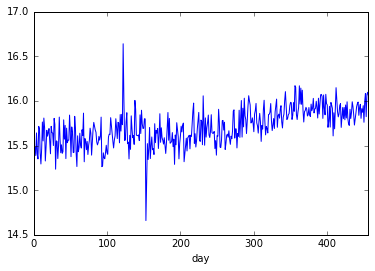

In [125]:
ts = train_wide[train_wide.columns[65]]
ts.plot()

Скользящаяя средняя заходит нормально - с параметром 0.03 почти как полноценная модель

In [145]:
for a in [0.001, 0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.3]:
    mses = []
    for c in train_wide.columns:
        ts = train_wide[c]
        mse = mean((ts.ewm(alpha=a).mean().shift(1).fillna(mean(ts))-ts).tail(30)**2) 
        mses.append(mse)
    print(sqrt(mean(mses)))

1.62927105709
1.56990504618
1.552358678
1.54745223327
1.54810287029
1.55344055454
1.56425271849
1.65322963533


Регрессия каждого кода на другие -ок, если зарегуляризовывать на 10 тыщ

In [165]:
for alpha in [1, 10, 100, 1000, 1e4, 1e5, 1e6]:
    mses = []
    for c in train_wide.columns:
        x = train_wide[train_wide.columns.difference([c])]
        y = train_wide[c]
        reg = Ridge(alpha = alpha)
        tr_size = x.shape[0]-30
        reg.fit(x.head(tr_size), y.head(tr_size))
        mses.append(mean((reg.predict(x.tail(30))-y.tail(30))**2))
    print(sqrt(mean(mses)))

1.94693784437
1.88504067348
1.74154770151
1.59527380742
1.58396827211
1.63436186361
1.64643140815


делаю машинку для запоминания

In [170]:
mses = []
col_others = dict()
reg_others = dict()
for c in train_wide.columns:
    x = train_wide[train_wide.columns.difference([c])]
    y = train_wide[c]
    reg = Ridge(alpha = 1e4)
    tr_size = x.shape[0]-30
    reg.fit(x.head(tr_size), y.head(tr_size))
    mses.append(mean((reg.predict(x.tail(30))-y.tail(30))**2))
    reg_others[c] = reg
    col_others[c] = x.columns
print(sqrt(mean(mses)))

1.58396827211


Оказывается, можно немножко сдвигать к предсказанию по другим кодам, и будет ок.

In [182]:
oth_share = 0.20
def move_to_reg_others(pset):
    plane = pset[1].copy()
    for c in pset[1].columns:
        plane[c] = reg_others[c].predict(pset[1][col_others[c]])
    pred = (1-oth_share) * pset[1] + oth_share * plane
    return pset[0], pred
ridge_alpha = 30
evaluate_things(train_wide, features = [add_time_features_01, add_trend_breaks, add_weekday_dummies]
                                  , estimator = [extrapolate_02], post_estimator = [move_to_reg_others])

1.5377954911793033

In [183]:
sub = make_submission(train_wide, features = [add_time_features_01, add_trend_breaks, add_weekday_dummies]
                                  , estimator = [extrapolate_02], post_estimator = [move_to_reg_others])

In [184]:
sub[['mcc_code', 'day', 'volume']].to_csv('b_06.csv', index=False)

Удаление ненужных столбцов не помогает.

In [187]:
def remove_days(df):
    # убираю тупые фичи
    df.drop('week_day', axis = 1, inplace = True)
    df.drop('month_day', axis = 1, inplace = True)
    return df
evaluate_things(train_wide, features = [add_time_features_01, add_trend_breaks, add_weekday_dummies, remove_days]
                                  , estimator = [extrapolate_02], post_estimator = [move_to_reg_others])

1.5378335101971998

####  splines!

Сплайны чегой-та расходятся, вместо того, чтоб сходиться, как нормальные люди.

In [188]:
from scipy.interpolate import UnivariateSpline

In [213]:
mses = []
for c in train_wide.columns[0:5]:
    y = train_wide[c]
    tr_size = y.shape[0]-30
    spl = UnivariateSpline(arange(tr_size), y.head(tr_size))
    pr = spl(arange(tr_size, tr_size + 30))
    mses.append(mean((pr-y.tail(30))**2))
print(sqrt(mean(mses)))

53676.7762478


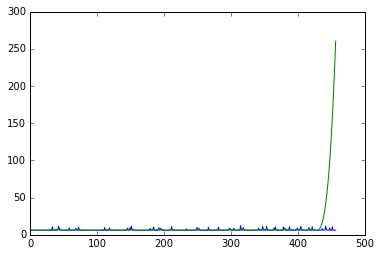

In [214]:
plot(y)
plot(spl(arange(len(y))))

### те самые логистические брейки

In [215]:
ridge_alpha = 30
log_break_w = 50
evaluate_things(train_wide, features = [add_time_features_01, add_logistic_breaks, add_weekday_dummies]
                                  , estimator = [extrapolate_02])

1.5372372493917985

In [216]:
sub = make_submission(train_wide, features = [add_time_features_01, add_logistic_breaks, add_weekday_dummies]
                                  , estimator = [extrapolate_02])
sub[['mcc_code', 'day', 'volume']].to_csv('b_07.csv', index=False)

#### от бзысходности пытаюсь и правда скользящую среднюю натянуть

In [217]:
base_sub = make_submission(train_wide, features = [add_time_features_01, add_trend_breaks, add_weekday_dummies]
                , estimator = [extrapolate_02])

In [220]:
base_pred = base_sub.pivot('day', 'mcc_code', 'lamount')

In [224]:
learn_and_pred = pd.concat([train_wide, base_pred], axis = 0)
train_wide.shape, learn_and_pred.shape

((457, 184), (487, 184))

In [229]:
learn_and_pred_ewma = learn_and_pred.copy()
for c in learn_and_pred_ewma.columns:
    learn_and_pred_ewma[c] = learn_and_pred[c].ewm(alpha = 0.03).mean()

In [239]:
pred_ewma = learn_and_pred_ewma.tail(30)*0.05+base_pred*0.95

In [244]:
new_sub = lamount_to_volume(wide_to_long(pred_ewma))
new_sub.head()

,mcc_code,day,lamount,volume
0,742,457,9.171406,9118.138183
1,742,458,8.471090,4274.716148
2,742,459,8.872839,6635.510771
3,742,460,8.625682,5072.959974
4,742,461,8.803710,6158.904019


In [245]:
new_sub[['mcc_code', 'day', 'volume']].to_csv('b_08.csv', index=False)

In [246]:
pred_ewma = learn_and_pred_ewma.tail(30)*0.01+base_pred*0.99
new_sub = lamount_to_volume(wide_to_long(pred_ewma))
new_sub.head()
new_sub[['mcc_code', 'day', 'volume']].to_csv('b_09.csv', index=False)

Вердикт: я не знаю, чё с временными рядами можно сделать за такой короткий срок. Я перехожу к плану C, бросаю силы на задачу 3